# Synthesize Speech from Text

This notebook is used to explore synthesizing speech from text.

In [173]:
%matplotlib inline

import sys

# Setup the "PYTHONPATH"
sys.path.insert(0, '../')

## Browse Checkpoints

Print all the possible checkpoints.

In [174]:
import re

def natural_keys(text):
    """ Keys used to sort in human order.
    
    Learn More:
        - http://nedbatchelder.com/blog/200712/human_sorting.html
    """
    return [(int(c) if c.isdigit() else c) for c in re.split('(\d+)', str(text))]


def get_checkpoints(base_path, pattern='checkpoints/**/*.pt'):
    """ Prints and returns all checkpoints in ``base_path``.
    """
    paths = [p for p in base_path.glob(pattern)]
    paths = sorted(paths, key=lambda p: natural_keys(p.name))
    print('Checkpoints found for base path %s' % base_path)
    for i, path in enumerate(paths):
        print('%d. %s' % (i, path.relative_to(base_path)))
    print('-'*100)
    return paths

In [175]:
from pathlib import Path

root_path = Path('/home/michaelp/WellSaid-Labs-Text-To-Speech/experiments/')

feature_model_path = root_path / 'feature_model/09_16/post_net_no_dropout/'
# NOTE: Index 208 was used to train the signal model
feature_model_path = get_checkpoints(feature_model_path)[208]

signal_model_path = root_path / 'signal_model/09_28/feature_model_post_net_no_dropout/'
signal_model_path = get_checkpoints(signal_model_path)[-2]

print('Using feature model checkpoint %s' % feature_model_path.relative_to(root_path))
print('Using signal model checkpoint %s' % signal_model_path.relative_to(root_path))

Checkpoints found for base path /home/michaelp/WellSaid-Labs-Text-To-Speech/experiments/feature_model/09_16/post_net_no_dropout
0. checkpoints/1537071337/step_1.pt
1. checkpoints/1537071337/step_941.pt
2. checkpoints/1537071337/step_1881.pt
3. checkpoints/1537071337/step_2821.pt
4. checkpoints/1537071337/step_3761.pt
5. checkpoints/1537071337/step_4701.pt
6. checkpoints/1537071337/step_5641.pt
7. checkpoints/1537071337/step_6581.pt
8. checkpoints/1537071337/step_7521.pt
9. checkpoints/1537071337/step_8461.pt
10. checkpoints/1537071337/step_9401.pt
11. checkpoints/1537071337/step_10341.pt
12. checkpoints/1537071337/step_11281.pt
13. checkpoints/1537071337/step_12221.pt
14. checkpoints/1537071337/step_13161.pt
15. checkpoints/1537071337/step_14101.pt
16. checkpoints/1537071337/step_15041.pt
17. checkpoints/1537071337/step_15981.pt
18. checkpoints/1537071337/step_16921.pt
19. checkpoints/1537071337/step_17861.pt
20. checkpoints/1537071337/step_18801.pt
21. checkpoints/1537071337/step_1974

## Load checkpoints

In [176]:
import torch

from src.utils import load_checkpoint
from src.bin.feature_model._utils import set_hparams

set_hparams()
checkpoint = load_checkpoint(feature_model_path, torch.device('cuda'))
text_encoder = checkpoint['text_encoder']
feature_model = checkpoint['model']
'Loaded feature model at step %d' % checkpoint['step']

INFO:src.utils.utils:Loading: /home/michaelp/WellSaid-Labs-Text-To-Speech/experiments/feature_model/09_16/post_net_no_dropout/checkpoints/1538001059/step_289899.pt


'Loaded feature model at step 289899'

In [177]:
from src.utils import load_checkpoint
from src.bin.signal_model._utils import set_hparams

set_hparams()
checkpoint = load_checkpoint(signal_model_path, torch.device('cpu'))
signal_model = checkpoint['model']
'Loaded signal model at step %d' % checkpoint['step']

INFO:src.utils.utils:Loading: /home/michaelp/WellSaid-Labs-Text-To-Speech/experiments/signal_model/09_28/feature_model_post_net_no_dropout/checkpoints/1538601423/step_2217350.pt


'Loaded signal model at step 2217350'

## Predict

In [385]:
text = 'Commercialism again compels the use of type too small in size to be comfortable reading.'

In [386]:
# Ensure your text does not contain unknown characters
assert text_encoder.decode(text_encoder.encode(text)) == text

torch.set_grad_enabled(False)
feature_model.eval()
_ = signal_model.eval() # ``_ = `` prevents printing

Below we temporarly adapt ``_get_stopped_indexes`` to allow us to set the ``stop_threshold`` if the model continues for too long.

In [387]:
from functools import partial

def _get_stopped_indexes(self, predictions, stop_threshold=0.5):
    """ Get a list of indices that predicted stop.

    Args:
        stop_token (torch.FloatTensor [1, batch_size]): Probablity of stopping.

    Returns:
        (list) Indices that predicted stop.
    """
    stopped = predictions.data.view(-1).ge(stop_threshold).nonzero()
    if stopped.dim() > 1:
        return stopped.squeeze(1).tolist()
    else:
        return []
        
feature_model._get_stopped_indexes = partial(_get_stopped_indexes, feature_model)

In [400]:
from IPython.display import Audio

from matplotlib import pyplot

from src.utils import plot_log_mel_spectrogram
from src.utils import plot_attention
from src.utils import plot_stop_token
from src.audio import griffin_lim

encoded = text_encoder.encode(text)
encoded = encoded.unsqueeze(1).to(torch.device('cuda'))
# predicted_frames [num_frames, batch_size, frame_channels]
_, predicted_frames, predicted_stop, predicted_alignment = feature_model(tokens=encoded)

# _ = plot_log_mel_spectrogram(predicted_frames[:, 0].cpu().numpy()).set_size_inches(15,8)
# _ = plot_attention(predicted_alignment[:, 0].cpu().numpy()).set_size_inches(15,8)
# _ = plot_stop_token(predicted_stop[:, 0].cpu().numpy()).set_size_inches(15,8)
Audio(griffin_lim(predicted_frames[:, 0].cpu().numpy()))

100%|██████████| 30/30 [00:01<00:00, 19.33it/s]


In [401]:
from src.utils import combine_signal 

# [num_frames, batch_size, frame_channels] → [num_frames, frame_channels]
predicted_frames = predicted_frames.squeeze(1)
padded_predicted_frames = torch.nn.functional.pad(predicted_frames, (0, 0, 5, 5)).cpu()
padded_predicted_frames = padded_predicted_frames.unsqueeze(0)
print('Padded spectrogram Shape:', padded_predicted_frames.shape)
# [batch_size, signal_length]
predicted_coarse, predicted_fine, _ = signal_model.infer(padded_predicted_frames)

predicted_coarse = predicted_coarse.squeeze(0).cpu()
predicted_fine = predicted_fine.squeeze(0).cpu()
signal = combine_signal(predicted_coarse, predicted_fine)

Padded spectrogram Shape: torch.Size([1, 387, 128])


100%|██████████| 113100/113100 [01:16<00:00, 1470.77it/s]


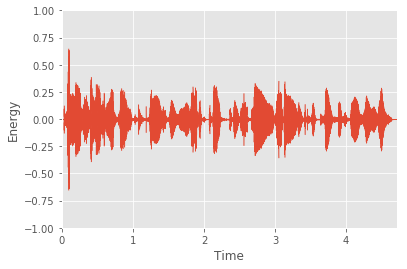

In [402]:
from src.utils import plot_waveform

_ = plot_waveform(signal.numpy())

In [403]:
from IPython.display import Audio

Audio(signal.numpy())